> **Note:** To maintain a concise notebook and avoid excessive output, DataFrame displays are limited to key steps and final results. Intermediate displays were verified and removed to optimize space.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 50)

**DATA IMPORT**

In [3]:
clubs_data = pd.read_csv('C:\\Users\\Admin\\Downloads\\clubs data.csv')  
games_data = pd.read_csv('C:\\Users\\Admin\\Downloads\\games data.csv')   
game_events_data = pd.read_csv('C:\\Users\\Admin\\Downloads\\game_events data.csv')  
appearances_data = pd.read_csv('C:\\Users\\Admin\\Downloads\\appearances.csv')  

*Taking a look at columns contained in every table simultaneously*

In [4]:
tables = {  
    'Games Data': games_data,  
    'Appearances Data': appearances_data,    
    'Clubs Data': clubs_data,  
    'Game Events Data': game_events_data  
}  

for name, df in tables.items():  
    print(f"{name} Columns: {list(df.columns)}") 

Games Data Columns: ['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals', 'home_club_position', 'away_club_position', 'home_club_manager_name', 'away_club_manager_name', 'stadium', 'attendance', 'referee', 'url', 'home_club_formation', 'away_club_formation', 'home_club_name', 'away_club_name', 'aggregate', 'competition_type']
Appearances Data Columns: ['appearance_id', 'game_id', 'player_id', 'player_club_id', 'player_current_club_id', 'date', 'player_name', 'competition_id', 'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played']
Clubs Data Columns: ['club_id', 'club_code', 'name', 'domestic_competition_id', 'total_market_value', 'squad_size', 'average_age', 'foreigners_number', 'foreigners_percentage', 'national_team_players', 'stadium_name', 'stadium_seats', 'net_transfer_record', 'coach_name', 'last_season', 'filename', 'url']
Game Events Data Columns: ['game_event_id', 'date', 'game_id', 'minute', 

**Filtering for Spanish Football clubs and competitions Only**

>This analysis is for Spanish football clubs and competitions. Spanish teams and competitions are filtered using the competition Id on each table.

In [5]:
games_data_ESP= games_data[games_data['competition_id'].isin(['ES1'])] 
clubs_data_ESP = clubs_data[clubs_data['domestic_competition_id'].isin(['ES1'])] 
appearances_data_ESP = appearances_data[appearances_data['competition_id'].isin(['ES1'])]

>Game_events_data does not have a column with which Spanish teams or competitions can be filtered, therefore, this table is filtered off the games_data_ESP table using the Game_ID column below.

In [6]:
game_events_ESP = game_events_data[game_events_data['game_id'].isin(games_data_ESP['game_id'])]

**DATA CLEANING**

*Creating a dictionary that stores all the tables to facilitate iterative processing*

In [7]:
tables_ESP2 = {  
    'Games Data ESP': games_data_ESP,  
    'Appearances Data ESP': appearances_data_ESP,   
    'Clubs Data ESP': clubs_data_ESP,  
    'Game Events Data ESP': game_events_ESP }

***Dropping Duplicates and Unnecessary Columns***

In [8]:
#checking for tables with duplicates
for name, df in tables_ESP2.items():  
    has_duplicates = df.duplicated().any()  
    
    print(f"{name} - Has duplicates: {has_duplicates}")

Games Data ESP - Has duplicates: False
Appearances Data ESP - Has duplicates: False
Clubs Data ESP - Has duplicates: False
Game Events Data ESP - Has duplicates: False


*Dropping unneeded columns from tables*. More columns will be dropped subsequently if they are at any point considered a threat to data integrity in this analysis.

In [9]:
tables_ESP= tables_ESP2.copy()

In [10]:
clubs_data_ESP.loc[clubs_data_ESP['club_code'] == 'fc-barcelona', 'stadium_seats'] = 99354

In [11]:
# Defining columns to be dropped on each DataFrame
columns_to_drop = {  
    'Games Data ESP': ['url', 'competition_type'],    
    'Clubs Data ESP': ['filename', 'url', 'coach_name', 'total_market_value'],
    'Appearances Data ESP':['competition_id'],
    'Game Events Data ESP':['description']
}

# Looping through the dictionary to drop the specified columns  
for name, df in tables_ESP2.items():  
    if name in columns_to_drop:  
        tables_ESP2[name] = df.drop(columns=columns_to_drop[name])

In [12]:
#Saving changes to individual table variables(other tables are saved subsequently as changes are made on them)
appearances_data_ESP = tables_ESP2['Appearances Data ESP']
clubs_data_ESP = tables_ESP2['Clubs Data ESP']

***Handling missing data***

In [13]:
#Checking for tables and columns with missing data
for name, df in tables_ESP2.items():  
    print(f"{name} - Missing values:\n{df.isnull().sum()}")

Games Data ESP - Missing values:
game_id                     0
competition_id              0
season                      0
round                       0
date                        0
home_club_id                0
away_club_id                0
home_club_goals             0
away_club_goals             0
home_club_position          0
away_club_position          0
home_club_manager_name      2
away_club_manager_name      2
stadium                     0
attendance                489
referee                     5
home_club_formation       431
away_club_formation       430
home_club_name              0
away_club_name              0
aggregate                   0
dtype: int64
Appearances Data ESP - Missing values:
appearance_id             0
game_id                   0
player_id                 0
player_club_id            0
player_current_club_id    0
date                      0
player_name               0
yellow_cards              0
red_cards                 0
goals                     0
assis

*Missing Values are resolved one table after another*

<u>Games Data ESP<u>

>To address missing values in the attendance column of the games data (ESP), targeted imputation approach is used. Missing attendance values is replaced with the average attendance of each respective home club, calculated from their home matches.


In [14]:
# Filtering for home matches 
games_data_ESP = tables_ESP2['Games Data ESP']  
home_games = games_data_ESP[games_data_ESP['home_club_id'].notnull()] 

# Calculating the mean attendance for each home club 
mean_attendance = home_games.groupby('home_club_id')['attendance'].mean().reset_index()
mean_attendance.columns = ['home_club_id', 'mean_attendance'] 

# Merging the mean attendance back to the original DataFrame 
games_data_ESP = pd.merge(games_data_ESP, mean_attendance, how='left', on='home_club_id') 

# Filling missing values in attendance column 
games_data_ESP['attendance'] = games_data_ESP['attendance'].fillna(games_data_ESP['mean_attendance'])

#Dropping the mean_attendance column as it's no longer needed 
games_data_ESP.drop(columns=['mean_attendance'], inplace=True)  

tables_ESP2['Games Data ESP'] = games_data_ESP 

>The missing values in the home_club_formation and away_club_formation columns are filled with respective club's most common formation gotten using the mode method, this is to preserve every club's playing style, ensure data integrity and control the impact of missing data on the analysis.

In [15]:
# Filling home formations based on the most common for each club  
games_data_ESP['home_club_formation'] = games_data_ESP.groupby('home_club_id')['home_club_formation'].transform(  
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')  
)  

# Filling away formations similarly  
games_data_ESP['away_club_formation'] = games_data_ESP.groupby('away_club_id')['away_club_formation'].transform(  
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')  
)

>The missing values in coach's and referees' columns on games_data(ESP) are identified, sourced from reliable platforms and entered manually

In [16]:
games_data_ESP.loc[games_data_ESP['home_club_manager_name'].isnull(), 'home_club_manager_name'] = [  
    'Jorge Almiron', 'Jorge Almiron']  
games_data_ESP.loc[games_data_ESP['away_club_manager_name'].isnull(), 'away_club_manager_name'] = [  
    'Javi Gracia', 'Diego Martinez']    
games_data_ESP.loc[games_data_ESP['referee'].isnull(), 'referee'] = [  
    'Santiago Jaime Latre','Santiago Jaime Latre', 'Santiago Jaime Latre','Mario Melero', 'Santiago Jaime Latre']

<u>Game Events Data ESP<u>

>The following missing value replacements are made based on column-specific information:
>- player_in_id Column
    - NaN values replaced with -1, serving as a placeholder to indicate the player was not substituted during the game.
>- player_assist_id Column
    - NaN values replaced with -2, indicating the player did not provide any assists in the game.

In [17]:
game_events_ESP = tables_ESP2['Game Events Data ESP']
game_events_ESP['player_in_id'] = game_events_ESP['player_in_id'].fillna(-1)
game_events_ESP['player_assist_id']= game_events_ESP['player_assist_id'].fillna(-2)

In [18]:
#Confirming all missing values have been resolved
for name, df in tables_ESP2.items():
    has_nan = df.isnull().values.any()
    print(f"{name} - Has NaN: {has_nan}")

Games Data ESP - Has NaN: False
Appearances Data ESP - Has NaN: False
Clubs Data ESP - Has NaN: False
Game Events Data ESP - Has NaN: False


**DATA TRANSFORMATION AND REFINING**

In [19]:
#checking datatypes of each column to ensure consistency of column dtypes with data they contain
for table_name, df in tables_ESP2.items():
    print(f"{table_name} dtypes:")
    print(df.dtypes)
    print()

Games Data ESP dtypes:
game_id                     int64
competition_id             object
season                      int64
round                      object
date                       object
home_club_id                int64
away_club_id                int64
home_club_goals             int64
away_club_goals             int64
home_club_position        float64
away_club_position        float64
home_club_manager_name     object
away_club_manager_name     object
stadium                    object
attendance                float64
referee                    object
home_club_formation        object
away_club_formation        object
home_club_name             object
away_club_name             object
aggregate                  object
dtype: object

Appearances Data ESP dtypes:
appearance_id             object
game_id                    int64
player_id                  int64
player_club_id             int64
player_current_club_id     int64
date                      object
player_name          

*Converting different columns to dtypes consistent with the values they contain.*

In [20]:
#games_data_ESP
games_data_ESP['date'] = pd.to_datetime(games_data_ESP['date'])
games_data_ESP['home_club_position'] = games_data_ESP['home_club_position'].astype(int)
games_data_ESP['away_club_position'] = games_data_ESP['away_club_position'].astype(int)
games_data_ESP['attendance'] = games_data_ESP['attendance'].astype(int)
tables_ESP2['Games Data ESP'] = games_data_ESP

In [21]:
# appearances_data_ESP
appearances_data_ESP['date'] = pd.to_datetime(appearances_data_ESP['date'])
tables_ESP2['Appearances Data ESP'] = appearances_data_ESP

In [22]:
#game_events_ESP
game_events_ESP['date'] = pd.to_datetime(game_events_ESP['date'])
game_events_ESP['player_in_id'] = game_events_ESP['player_in_id'].astype(int)
game_events_ESP['player_assist_id'] =game_events_ESP['player_assist_id'].astype(int)
tables_ESP2['Games Events Data ESP'] = game_events_ESP

In [23]:
#clubs_data_ESP, converting net_transfer_record to floats and changing the data format
def convert_net_transfer(x):
    if 'm' in x:
        return float(x.replace('€', '').replace('m', '')) * 1e6
    elif 'k' in x:
        return float(x.replace('€', '').replace('k', '')) * 1e3
    else:
        return float(x.replace('€', ''))

# Applying the function and convert to float
clubs_data_ESP['net_transfer_record'] = clubs_data_ESP['net_transfer_record'].apply(convert_net_transfer).astype(float)

<u>Games Data ESP<u>

*Viewing Relevant Columns for Data Cleaning*

>To maintain a concise notebook and focus on columns requiring attention, unique values from the following columns are selectively displayed:
>- home_club_formation
>- away_club_formation
>- round
>- aggregate

In [24]:
print(games_data_ESP[['home_club_formation', 'away_club_formation','round','aggregate']].apply(lambda x: x.unique()))

home_club_formation    [4-2-3-1, 4-3-3 Attacking, 4-4-2 double 6, 4/5...
away_club_formation    [4-1-4-1, 4-2-3-1, 4-3-3 Attacking, 4-3-3 Defe...
round                  [4. Matchday, 27. Matchday, 9. Matchday, 14. M...
aggregate              [3:02, 0:02, 0:01, 7:00, 1:01, 1:00, 0:00, 2:0...
dtype: object


*Extracting main formation patterns from home_club_formation and away_club_formation columns*

In [25]:
games_data_ESP['home_club_formation'] = games_data_ESP['home_club_formation'].str.split().str[0]
games_data_ESP['away_club_formation'] = games_data_ESP['away_club_formation'].str.split().str[0]

*Standardizing home_club_formation and away_club_formation columns by converting date-formatted entries (e.g., 4/4/2002) to conventional formation entries (e.g., 4-4-2).*

In [26]:
#away_club_formation
def fix_formation(x):
    if '/' in x and len(x.split('/')[-1]) == 4:
        formation_parts = x.split('/')[:-1] 
        year_last_digit = x.split('/')[-1][-1] 
        formation_parts.append(year_last_digit)
        return '-'.join(formation_parts)
    return x
games_data_ESP['away_club_formation'] = games_data_ESP['away_club_formation'].apply(fix_formation)

In [27]:
#home_club_formation
def fix_formation(x):
    if '/' in x and len(x.split('/')[-1]) == 4:  
        formation_parts = x.split('/')[:-1] 
        year_last_digit = x.split('/')[-1][-1] 
        formation_parts.append(year_last_digit)
        return '-'.join(formation_parts)
    return x
games_data_ESP['home_club_formation'] = games_data_ESP['home_club_formation'].apply(fix_formation)

In [28]:
print(games_data_ESP[['home_club_formation', 'away_club_formation']].apply(lambda x: x.unique()))

home_club_formation    [4-2-3-1, 4-3-3, 4-4-2, 4-5-1, 5-3-2, 4-1-4-1,...
away_club_formation    [4-1-4-1, 4-2-3-1, 4-3-3, 4-4-2, 3-5-2, 3-4-2-...
dtype: object


*Removing unnecessary '. Matchday' suffix from 'round' column, retaining only the numerical values.*

In [29]:
games_data_ESP['round'] = games_data_ESP['round'].str.split('. ').str[0].astype(int)

*Removing leading zeros from 'aggregate' column.*

In [30]:
games_data_ESP['aggregate'] = games_data_ESP['aggregate'].str.replace(':0', ':')

In [31]:
print(games_data_ESP[['home_club_formation', 'away_club_formation','round','aggregate']].apply(lambda x: x.unique()))

home_club_formation    [4-2-3-1, 4-3-3, 4-4-2, 4-5-1, 5-3-2, 4-1-4-1,...
away_club_formation    [4-1-4-1, 4-2-3-1, 4-3-3, 4-4-2, 3-5-2, 3-4-2-...
round                  [4, 27, 9, 14, 15, 28, 33, 6, 11, 31, 1, 3, 8,...
aggregate              [3:2, 0:2, 0:1, 7:0, 1:1, 1:0, 0:0, 2:1, 1:2, ...
dtype: object


*Renaming 'round' and 'aggregate' columns to better reflect their content.*

In [32]:
games_data_ESP = games_data_ESP.rename(columns={
    'round': 'matchday',
    'aggregate': 'aggregate_score'})

New variables/columns are generated for ease in uncovering  hidden patterns

*Creating a home and away points columns for the games_data_ESP table*

In [33]:
games_data_ESP['home_points'] = games_data_ESP.apply(lambda row: 3 if row['home_club_goals'] > row['away_club_goals'] else 1 if row['home_club_goals'] == row['away_club_goals'] else 0, axis=1)
games_data_ESP['away_points'] = games_data_ESP.apply(lambda row: 3 if row['away_club_goals'] > row['home_club_goals'] else 1 if row['away_club_goals'] == row['home_club_goals'] else 0, axis=1)


<u>Clubs Data ESP<u>

I calculated various club performance metrics, including home/away win/draw/loss percentages, average goals scored/conceded, average points earned, and average attendance. These metrics were added to the clubs data table to ease further analysis and comparison of team performance. This dataset provides a solid foundation for further exploration and visualization.

In [34]:
# Calculate Win and Draw Percentages
percentages = games_data_ESP.groupby('home_club_id').apply(
    lambda x: pd.Series({
        'home_win_percentage': ((x['home_points'] > x['away_points'])).mean() * 100,
        'home_draw_percentage': ((x['home_points'] == x['away_points'])).mean() * 100
    })
).reset_index()
percentages = percentages.rename(columns={'home_club_id': 'club_id'})

away_percentages = games_data_ESP.groupby('away_club_id').apply(
    lambda x: pd.Series({
        'away_win_percentage': ((x['away_points'] > x['home_points'])).mean() * 100,
        'away_draw_percentage': ((x['away_points'] == x['home_points'])).mean() * 100
    })
).reset_index()
away_percentages = away_percentages.rename(columns={'away_club_id': 'club_id'})

# Merging Home and Away Percentages
percentages = pd.merge(percentages, away_percentages, on='club_id', how='outer')

# Merging Percentages with Clubs_data_ESP
clubs_data_ESP = clubs_data_ESP.merge(percentages, on='club_id', how='left')

C:\Users\Admin\AppData\Local\Temp\ipykernel_17788\3290558323.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentages = games_data_ESP.groupby('home_club_id').apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_17788\3290558323.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  away_percentages = games_data_ESP.groupby('away_club_id').apply(


In [35]:
# Calculating metrics
metrics = games_data_ESP.groupby('home_club_id').apply(
    lambda x: pd.Series({
        'avg_home_goals_conceded': x['away_club_goals'].mean(),
        'avg_home_goals_scored': x['home_club_goals'].mean(),
        'avg_home_points': x['home_points'].mean(),
        'avg_attendance': x['attendance'].mean()
    })
).reset_index()
metrics = metrics.rename(columns={'home_club_id': 'club_id'})

away_metrics = games_data_ESP.groupby('away_club_id').apply(
    lambda x: pd.Series({
        'avg_away_goals_conceded': x['home_club_goals'].mean(),
        'avg_away_goals_scored': x['away_club_goals'].mean(),
        'avg_away_points': x['away_points'].mean()
    })
).reset_index()
away_metrics = away_metrics.rename(columns={'away_club_id': 'club_id'})

# Merging calculated metrics into clubs_data_ESP
clubs_data_ESP = pd.merge(clubs_data_ESP, metrics, on='club_id', how='left')
clubs_data_ESP = pd.merge(clubs_data_ESP, away_metrics, on='club_id', how='left')

# Replacing potential NaN values with 0 (optional)
clubs_data_ESP = clubs_data_ESP.fillna(0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17788\1108331764.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = games_data_ESP.groupby('home_club_id').apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_17788\1108331764.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  away_metrics = games_data_ESP.groupby('away_club_id').apply(


In [36]:
# Summing yellow and red cards for each team per game
team_cards = appearances_data_ESP.groupby(['game_id', 'player_club_id'])[['yellow_cards', 'red_cards']].sum().reset_index()
# Calculating average yellow and red cards per game for each team at home
home_cards_avg = team_cards.merge(games_data_ESP[['game_id', 'home_club_id']], on='game_id')
home_cards_avg = home_cards_avg[home_cards_avg['player_club_id'] == home_cards_avg['home_club_id']]
home_cards_avg = home_cards_avg.groupby('player_club_id')[['yellow_cards', 'red_cards']].mean().reset_index()
home_cards_avg = home_cards_avg.rename(columns={'player_club_id': 'club_id', 
                                                 'yellow_cards': 'avg_home_yellow_cards', 
                                                 'red_cards': 'avg_home_red_cards'})
# Calculating average yellow and red cards per game for each team away
away_cards_avg = team_cards.merge(games_data_ESP[['game_id', 'away_club_id']], on='game_id')
away_cards_avg = away_cards_avg[away_cards_avg['player_club_id'] == away_cards_avg['away_club_id']]
away_cards_avg = away_cards_avg.groupby('player_club_id')[['yellow_cards', 'red_cards']].mean().reset_index()
away_cards_avg = away_cards_avg.rename(columns={'player_club_id': 'club_id', 
                                                 'yellow_cards': 'avg_away_yellow_cards', 
                                                 'red_cards': 'avg_away_red_cards'})
# Merging with clubs_data_ESP
clubs_data_ESP = clubs_data_ESP.merge(home_cards_avg, on='club_id', how='left')
clubs_data_ESP = clubs_data_ESP.merge(away_cards_avg, on='club_id', how='left')

In [37]:
#Adding Attendance Percenatge Column
clubs_data_ESP['attendance_percentage'] = (clubs_data_ESP['avg_attendance'] / 
                                           clubs_data_ESP['stadium_seats']) * 100

In [38]:
#Rearranging columns
clubs_data_ESP = clubs_data_ESP[
['club_id', 'club_code', 'name', 'domestic_competition_id', 'squad_size', 'average_age',
'foreigners_number', 'foreigners_percentage', 'national_team_players', 'stadium_name',
'stadium_seats', 'net_transfer_record', 'last_season', 'home_win_percentage',
'away_win_percentage', 'home_draw_percentage', 'away_draw_percentage',
'avg_home_goals_scored', 'avg_away_goals_scored', 'avg_home_goals_conceded',
'avg_away_goals_conceded', 'avg_home_points', 'avg_away_points', 'avg_attendance','attendance_percentage',
'avg_home_yellow_cards', 'avg_away_yellow_cards', 'avg_home_red_cards',
'avg_away_red_cards']
]

In [39]:
games_data_ESP= games_data_ESP.reset_index(drop=True)
appearances_data_ESP= appearances_data_ESP.reset_index(drop=True)
clubs_data_ESP= clubs_data_ESP.reset_index(drop=True)
game_events_ESP= game_events_ESP.reset_index(drop=True)

>After applying data cleaning and transformation steps, the resulting datasets are shown below (Showing First Row of Each Table)

In [40]:
from IPython.display import display

display(games_data_ESP.head(1))
display(appearances_data_ESP.head(1))
display(clubs_data_ESP.head(1))
display(game_events_ESP.head(1))

,game_id,competition_id,season,matchday,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate_score,home_points,away_points
0,2341079,ES1,2013,4,2013-09-16,621,940,3,2,5,9,Ernesto Valverde,Luis Enrique,San Mamés,35686,Jesús Gil Manzano,4-2-3-1,4-1-4-1,Athletic Club Bilbao,Real Club Celta de Vigo S. A. D.,3:2,3,0


,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,yellow_cards,red_cards,goals,assists,minutes_played
0,2244383_119878,2244383,119878,940,1244,2012-08-18,Toni Dovale,0,0,0,0,11


,club_id,club_code,name,domestic_competition_id,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,last_season,home_win_percentage,away_win_percentage,home_draw_percentage,away_draw_percentage,avg_home_goals_scored,avg_away_goals_scored,avg_home_goals_conceded,avg_away_goals_conceded,avg_home_points,avg_away_points,avg_attendance,attendance_percentage,avg_home_yellow_cards,avg_away_yellow_cards,avg_home_red_cards,avg_away_red_cards
0,5358,sd-huesca,SD Huesca,ES1,24,27.50,8,33.30,2,El Alcoraz,9128,1430000.00,2020,26.32,10.53,34.21,31.58,1.08,0.95,1.34,1.76,1.13,0.63,6604.32,72.35,2.47,2.37,0.00,0.08


,game_event_id,date,game_id,minute,type,club_id,player_id,player_in_id,player_assist_id
0,4273ae3ebd6fe4a2b9f6fbdd7899d1bb,2012-08-25,2242827,48,Goals,940,3172,-1,72047


**DATA EXPLORATION AND ANALYSIS**

Calculated correlations for team performance,
I aggregated game-level data by home_club_id, calculating mean values to stabilize metrics and match club-level data. These mean values were merged with club-level data and used to calculate correlation coefficients, enabling a comprehensive analysis of relationships between game and club metrics.

With the above done, I calculated correlation coefficients between the following values:
- mean home and away_club_goals
- mean attendance
- average_age
- foreigners_percentage
- stadium_seats
- net_transfer_record
- mean home and away_points
- squad_size
- stadium_seats
- mean home and away yellow cards
- mean home and away red cards

Index(['home_club_id', 'attendance', 'home_club_goals', 'away_club_goals',
       'home_points', 'away_points', 'attendance_percentage', 'club_id',
       'avg_home_yellow_cards', 'avg_home_red_cards', 'avg_away_yellow_cards',
       'avg_away_red_cards', 'stadium_seats', 'average_age',
       'foreigners_percentage', 'squad_size', 'net_transfer_record'],
      dtype='object')


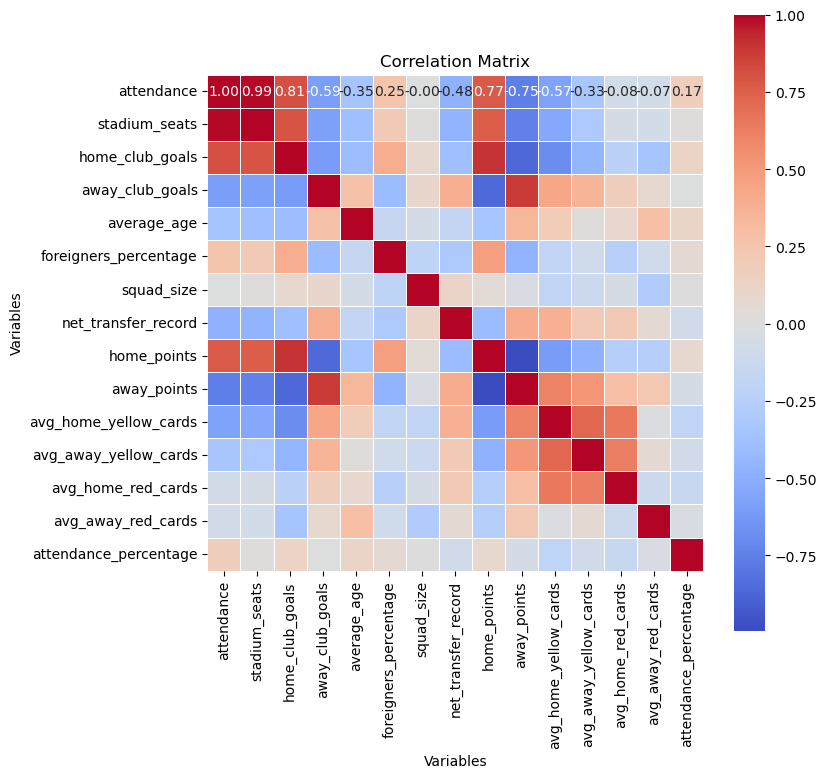

In [57]:
# Calculating average yellow and red cards per game for each team at home
team_cards = appearances_data_ESP.groupby(['game_id', 'player_club_id'])[['yellow_cards', 'red_cards']].sum().reset_index()
home_cards_avg = team_cards.merge(games_data_ESP[['game_id', 'home_club_id']], on='game_id')
home_cards_avg = home_cards_avg[home_cards_avg['player_club_id'] == home_cards_avg['home_club_id']]
home_cards_avg = home_cards_avg.groupby('player_club_id')[['yellow_cards', 'red_cards']].mean().reset_index()
home_cards_avg = home_cards_avg.rename(columns={'player_club_id': 'club_id', 'yellow_cards': 'avg_home_yellow_cards', 'red_cards': 'avg_home_red_cards'})

# Calculating average yellow and red cards per game for each team away
away_cards_avg = team_cards.merge(games_data_ESP[['game_id', 'away_club_id']], on='game_id')
away_cards_avg = away_cards_avg[away_cards_avg['player_club_id'] == away_cards_avg['away_club_id']]
away_cards_avg = away_cards_avg.groupby('player_club_id')[['yellow_cards', 'red_cards']].mean().reset_index()
away_cards_avg = away_cards_avg.rename(columns={'player_club_id': 'club_id', 'yellow_cards': 'avg_away_yellow_cards', 'red_cards': 'avg_away_red_cards'})

# Merging home and away cards averages
cards_avg = pd.merge(home_cards_avg, away_cards_avg, on='club_id')

# Grouping games_data_ESP by home_club_id and calculating mean
grouped_games_data = games_data_ESP.groupby('home_club_id')[[
    'attendance',
    'home_club_goals',
    'away_club_goals',
    'home_points',
    'away_points'
]].mean().reset_index()

# Calculating Attendance Percentage
grouped_games_data['attendance_percentage'] = (grouped_games_data['attendance'] / 
                                               grouped_games_data['home_club_id'].map(clubs_data_ESP.set_index('club_id')['stadium_seats'])) * 100
# Merging grouped games_data with cards_avg and clubs_data_ESP
merged_data = pd.merge(grouped_games_data, cards_avg, left_on='home_club_id', right_on='club_id')
merged_data = pd.merge(merged_data, clubs_data_ESP[['club_id', 'stadium_seats', 'average_age', 'foreigners_percentage', 'squad_size', 'net_transfer_record']], on='club_id')

# Verifying the columns
print(merged_data.columns)

# Selecting relevant variables
variables = [
    'attendance',
    'stadium_seats',
    'home_club_goals',
    'away_club_goals',
    'average_age',
    'foreigners_percentage',
    'squad_size',
    'net_transfer_record',
    'home_points',
    'away_points',
    'avg_home_yellow_cards',
    'avg_away_yellow_cards',
    'avg_home_red_cards',
    'avg_away_red_cards',
    'attendance_percentage'
]

# Checking if all variables are present in the merged_data
for var in variables:
    if var not in merged_data.columns:
        print(f"Column '{var}' not found.")

# Corrected indentation
    else:
        continue

# Calculating correlation matrix
corr_matrix = merged_data[variables].corr()

# Creating heatmap for correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

*From the Heatmap, the following observations are made*
>Key Insights from the Correlation Heatmap

1. Stadium Size and Attendance: A strong positive correlation exists between stadium size and attendance, indicating that larger venues attract more spectators. This, in turn, significantly enhances home team performance, with increased attendance linking to more home goals, points, and struggles for the away team.

2. Attendance and Discipline: The negative correlation between attendance and home yellow cards suggests that larger crowds promote more disciplined home team behavior, whereas lower attendance may lead to increased indiscipline.

3. Goal Scoring and Performance: In Spanish La Liga, goal scoring is crucial to team success. Conceding goals strongly correlates with losing, highlighting the importance of defensive solidity.

4. Squad Age and Performance: Squad age shows a notable correlation with team performance. A younger average age correlates with increased goal scoring and attendance, suggesting that younger squads have a positive influence on team success.

5. Squad Size and Transfer Spending: Notably, squad size does not correlate with attendance or performance. Additionally, higher transfer spending does not guarantee better results, indicating that other factors contribute to success.
6. Attendance Percentage: which is a metric that shows how filled up a stadium is calculated against its capacity, does not have any effect or impact on any of the other metrics in question.

**DATA VISUALIZATION AND INTERPRETATION**

Analysing teams by attendance and home games performance

**Attendance vs Performance Relationships**

I created a 3x3 subplot matrix to visualize relationships between average attendance and various football metrics, including home win percentage, yellow cards, goals scored/conceded, and away yellow cards. Additionally, I analyzed the correlation between attendance percentage and home points. These visualizations help identify potential factors influencing team performance and attendance. By examining these relationships, I would better understand how attendance impacted team success and identify areas for improvement.

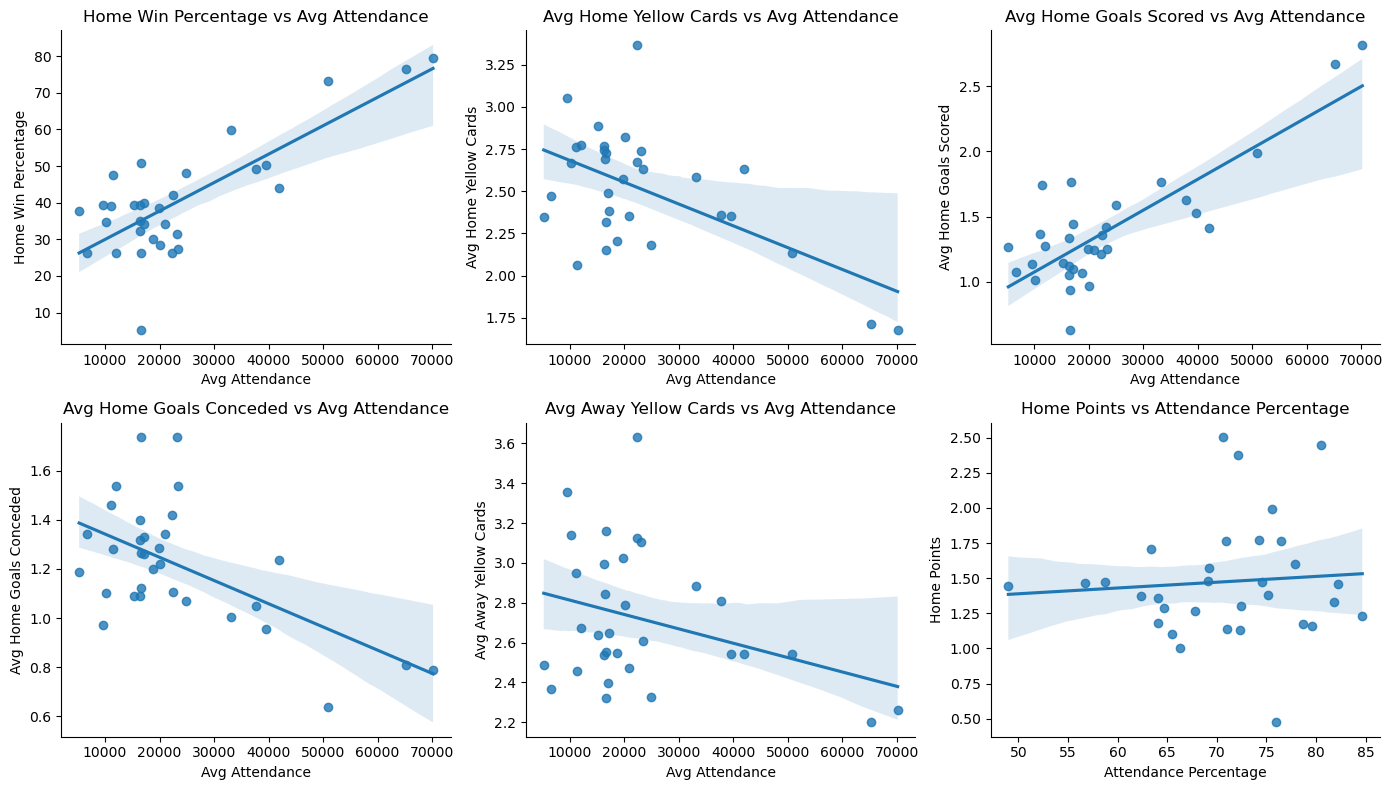

In [42]:
# Creating a figure with six subplots
fig, ax = plt.subplots(2, 3, figsize=(14, 8))

# Avg Attendance vs Home Win Percentage
sns.regplot(x='avg_attendance', y='home_win_percentage', data=clubs_data_ESP, ax=ax[0, 0])
ax[0, 0].set_title('Home Win Percentage vs Avg Attendance')
ax[0, 0].set_xlabel('Avg Attendance')
ax[0, 0].set_ylabel('Home Win Percentage')

# Avg Attendance vs Avg Home Yellow Cards
sns.regplot(x='avg_attendance', y='avg_home_yellow_cards', data=clubs_data_ESP, ax=ax[0, 1])
ax[0, 1].set_title('Avg Home Yellow Cards vs Avg Attendance')
ax[0, 1].set_xlabel('Avg Attendance')
ax[0, 1].set_ylabel('Avg Home Yellow Cards')

# Avg Attendance vs Avg Home Goals Scored
sns.regplot(x='avg_attendance', y='avg_home_goals_scored', data=clubs_data_ESP, ax=ax[0, 2])
ax[0, 2].set_title('Avg Home Goals Scored vs Avg Attendance')
ax[0, 2].set_xlabel('Avg Attendance')
ax[0, 2].set_ylabel('Avg Home Goals Scored')

# Avg Attendance vs Avg Home Goals Conceded
sns.regplot(x='avg_attendance', y='avg_home_goals_conceded', data=clubs_data_ESP, ax=ax[1, 0])
ax[1, 0].set_title('Avg Home Goals Conceded vs Avg Attendance')
ax[1, 0].set_xlabel('Avg Attendance')
ax[1, 0].set_ylabel('Avg Home Goals Conceded')

# Avg Attendance vs Avg Away Yellow Cards
sns.regplot(x='avg_attendance', y='avg_away_yellow_cards', data=clubs_data_ESP, ax=ax[1, 1])
ax[1, 1].set_title('Avg Away Yellow Cards vs Avg Attendance')
ax[1, 1].set_xlabel('Avg Attendance')
ax[1, 1].set_ylabel('Avg Away Yellow Cards')

# Attendance Percentage vs Home Points
sns.regplot(x='attendance_percentage', y='avg_home_points', data=clubs_data_ESP, ax=ax[1, 2])
ax[1, 2].set_title('Home Points vs Attendance Percentage')
ax[1, 2].set_xlabel('Attendance Percentage')
ax[1, 2].set_ylabel('Home Points')


# Removing top and right borders for all subplots
for subplot in ax.flat:
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**Home Team Performance**

I visualized the top 10 clubs by home points. I focused on home match performances due to the correlation observed earlier between home match attendance and home team success. By exploring the top performers in home matches, I sort to gain insight into which clubs capitalize most effectively on their home turf and to what extent home attendance and capacity influenced games.

To further investigate the relationship between home attendance and team performance, I visualized the top 10 clubs by average home attendance. This additional analysis allowed me to identify which clubs consistently drew large crowds and whether these clubs also excelled in their home matches. By comparing the top performers in home points and average home attendance, I aimed to uncover connections between fan support and team success, shedding light on the impact of home advantage observed earlier on the heatmap.

**Home Advantage Ratio**

To further quantify the impact of home advantage on teams' performance in the Spanish football league, I calculated the Home Advantage Ratio by dividing each team's home points by their total points. This analysis aimed to identify teams that excel at leveraging their home support, these are teams that show more strenght in home games compared to away, revealing varying degrees of home advantage. This insight helps identify strengths and weaknesses in teams' home performance.

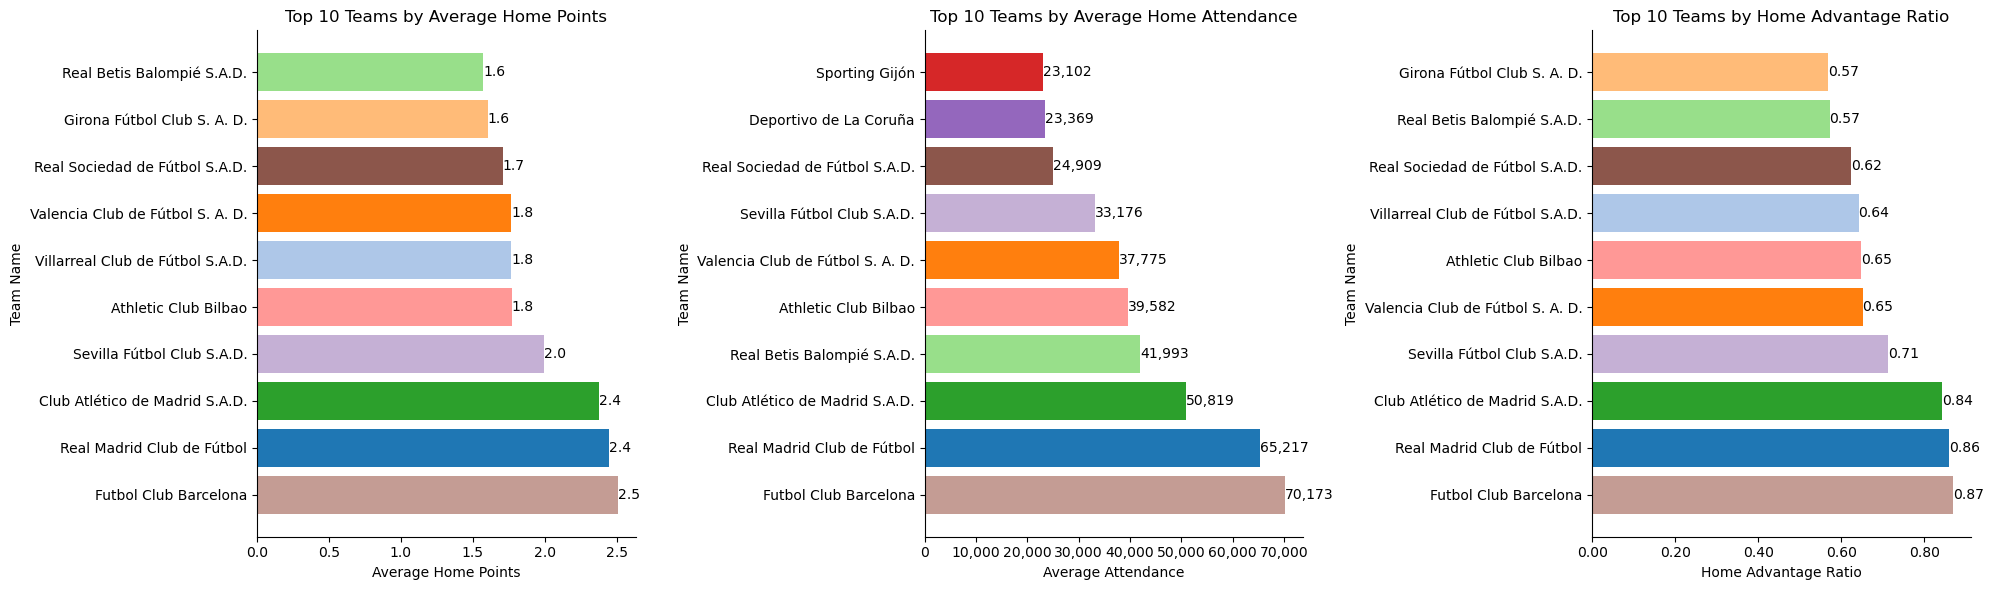

In [43]:
# Top 10 teams by average home points
top_10_home = clubs_data_ESP.nlargest(10, 'avg_home_points')

# Top 10 teams by average home attendance
top_10_attendance = games_data_ESP.groupby('home_club_id')['attendance'].mean().reset_index()
top_10_attendance = top_10_attendance.rename(columns={'home_club_id': 'club_id'})
top_10_attendance = top_10_attendance.nlargest(10, 'attendance')
top_10_attendance = top_10_attendance.merge(clubs_data_ESP[['club_id', 'name']], on='club_id', how='left')

# Home Advantage Ratio
games_data_ESP['total_points'] = games_data_ESP['home_points'] + games_data_ESP['away_points']
home_advantage_ratio = games_data_ESP.groupby('home_club_name')[['home_points', 'total_points']].sum().reset_index()
home_advantage_ratio['home_advantage_ratio'] = home_advantage_ratio['home_points'] / home_advantage_ratio['total_points']
top_teams = home_advantage_ratio.sort_values('home_advantage_ratio', ascending=False).head(10)

# Creating a dictionary mapping team names to unique colors
team_colors = {}
teams = list(set(list(top_10_home['name']) + list(top_10_attendance['name']) + list(top_teams['home_club_name'])))
for i, team in enumerate(teams):
    team_colors[team] = plt.cm.tab20(i % 20)

# Creating figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Average home points
ax[0].barh(top_10_home['name'], top_10_home['avg_home_points'], color=[team_colors[team] for team in top_10_home['name']])
ax[0].set_title('Top 10 Teams by Average Home Points')
ax[0].set_ylabel('Team Name')
ax[0].set_xlabel('Average Home Points')
ax[0].tick_params(axis='y', labelsize=10)
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1f}".format(x)))
for i, patch in enumerate(ax[0].patches):
    ax[0].text(patch.get_width(), patch.get_y() + patch.get_height()/2, f"{patch.get_width():.1f}", fontsize=10, ha='left', va='center')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Average home attendance
ax[1].barh(top_10_attendance['name'], top_10_attendance['attendance'], color=[team_colors[team] for team in top_10_attendance['name']])
ax[1].set_title('Top 10 Teams by Average Home Attendance')
ax[1].set_ylabel('Team Name')
ax[1].set_xlabel('Average Attendance')
ax[1].tick_params(axis='y', labelsize=10)
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))
for i, patch in enumerate(ax[1].patches):
    ax[1].text(patch.get_width(), patch.get_y() + patch.get_height()/2, f"{patch.get_width():,.0f}", fontsize=10, ha='left', va='center')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Home Advantage Ratio
ax[2].barh(top_teams['home_club_name'], top_teams['home_advantage_ratio'], color=[team_colors[team] for team in top_teams['home_club_name']])
ax[2].set_title('Top 10 Teams by Home Advantage Ratio')
ax[2].set_ylabel('Team Name')
ax[2].set_xlabel('Home Advantage Ratio')
ax[2].tick_params(axis='y', labelsize=10)
ax[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2f}".format(x)))
for i, patch in enumerate(ax[2].patches):
    ax[2].text(patch.get_width(), patch.get_y() + patch.get_height()/2, f"{patch.get_width():.2f}", fontsize=10, ha='left', va='center')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**Exploring Attendance Percentage**

To further investigate the impact of stadium capacity on attendance and team performance, I visualized the attendance percentage, calculated as the ratio of average attendance to stadium capacity(number_of_seats). This analysis aims to uncover the relationship between filling stadiums to full capacity and team success. By examining attendance percentage across teams, I seek to understand the correlation between stadium utilization and team performance. This visualization provides more insights into the interplay between attendance, stadium capacity, and team success.

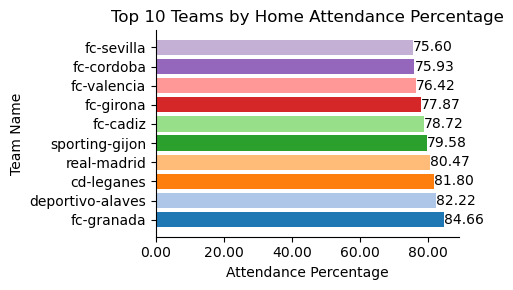

In [44]:
# Calculating attendance percentage
grouped_games_data['attendance_percentage'] = grouped_games_data['attendance'] / grouped_games_data['home_club_id'].map(clubs_data_ESP.set_index('club_id')['stadium_seats']) * 100

# Top 10 teams by attendance percentage
top_10_attendance_percentage = grouped_games_data.nlargest(10, 'attendance_percentage')
top_10_attendance_percentage = top_10_attendance_percentage.merge(clubs_data_ESP[['club_id', 'club_code']], left_on='home_club_id', right_on='club_id', how='left')

# Creating figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

ax.barh(top_10_attendance_percentage['club_code'], top_10_attendance_percentage['attendance_percentage'], color=plt.cm.tab20(np.arange(len(top_10_attendance_percentage))))
ax.set_title('Top 10 Teams by Home Attendance Percentage')
ax.set_xlabel('Attendance Percentage')
ax.set_ylabel('Team Name')
ax.tick_params(axis='y', labelsize=10)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2f}".format(x)))

# Adding value labels
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_width(), patch.get_y() + patch.get_height()/2, 
            f"{patch.get_width():.2f}", fontsize=10, ha='left', va='center')

# Hiding spines and grids
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='y', visible=False)
plt.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()

**Coach Performances in Home Games**

To better understand the dynamics of home advantage, I conducted an analysis of coach performances based on average points won in home games, focusing on managers with a minimum of 9 home games managed. This ensures that the insights drawn are based on consistent, long-term trends rather than short-term fluctuations.

The analysis has two complementary visualizations:

1. A heatmap highlighting manager-team performance correlations, revealing the relationships between coaching strategies and team outcomes in home games
2. Another heatmap showing manager-team performance correlations for away matches.

This examination aims to uncover the importance of coaching in leveraging home advantage, shedding light on the tactics and decisions that might drive victory in Spanish La Liga's home games.

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


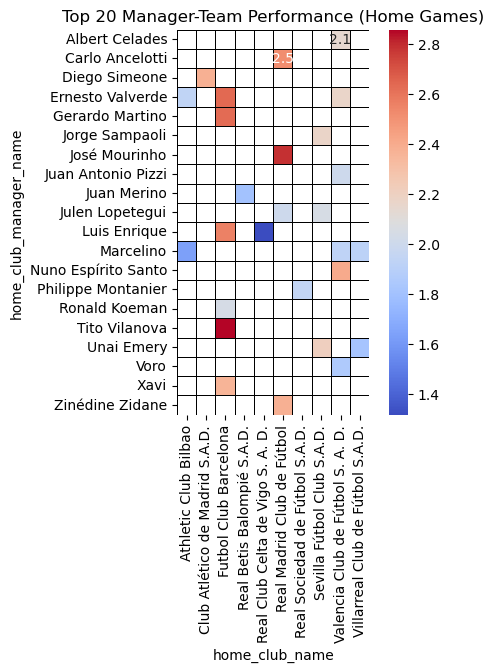

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


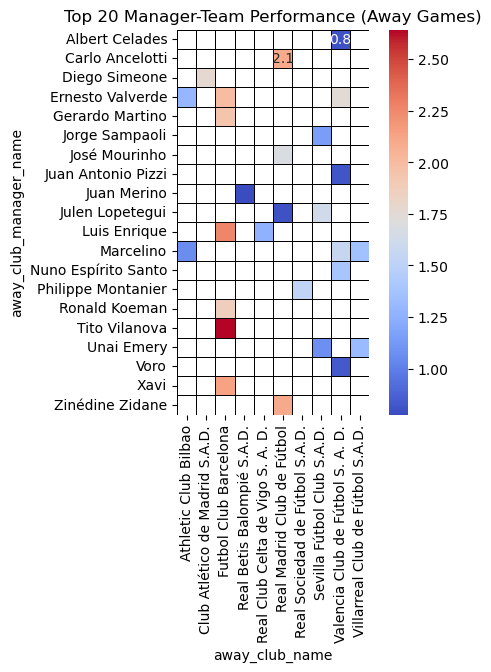

In [59]:
#Merging data for home games
home_games_data = pd.merge(games_data_ESP, clubs_data_ESP, left_on='home_club_id', right_on='club_id')

# Filtering managers with at least 9 home games
min_games_threshold = 9
manager_games_count = home_games_data['home_club_manager_name'].value_counts()
eligible_managers = manager_games_count[manager_games_count >= min_games_threshold].index
filtered_home_games_data = home_games_data[home_games_data['home_club_manager_name'].isin(eligible_managers)]

# Calculating home points metric
home_metrics = filtered_home_games_data.groupby('home_club_manager_name')['home_points'].mean().reset_index()

# Sorting values for better visualization
home_metrics = home_metrics.sort_values('home_points', ascending=False)

# Top 20 managers
top_20_managers = home_metrics.head(20)

# Correlating manager impact on team performance (Home Games)
team_manager_performance_home = filtered_home_games_data.groupby(['home_club_name', 'home_club_manager_name'])['home_points'].mean().reset_index()

# Filtering top 20 managers for heatmap
top_20_managers_names = top_20_managers['home_club_manager_name']
team_manager_performance_home_filtered = team_manager_performance_home[team_manager_performance_home['home_club_manager_name'].isin(top_20_managers_names)]

# Heatmap (Home Games)
manager_team_matrix_home = team_manager_performance_home_filtered.pivot_table(index='home_club_manager_name', columns='home_club_name', values='home_points')
plt.figure(figsize=(5,5))
sns.heatmap(manager_team_matrix_home, annot=True, cmap='coolwarm', square=True, linewidths=0.5, linecolor='black')
plt.title('Top 20 Manager-Team Performance (Home Games)')
plt.show()

# Merging data for away games
away_games_data = pd.merge(games_data_ESP, clubs_data_ESP, left_on='away_club_id', right_on='club_id')

# Filtering managers with at least 9 away games
away_games_data_filtered = away_games_data[away_games_data['away_club_manager_name'].isin(eligible_managers)]

# Correlating manager impact on team performance (Away Games)
team_manager_performance_away = away_games_data_filtered.groupby(['away_club_name', 'away_club_manager_name'])['away_points'].mean().reset_index()

# Filtering top 20 managers for heatmap
team_manager_performance_away_filtered = team_manager_performance_away[team_manager_performance_away['away_club_manager_name'].isin(top_20_managers_names)]

# Heatmap (Away Games)
manager_team_matrix_away = team_manager_performance_away_filtered.pivot_table(index='away_club_manager_name', columns='away_club_name', values='away_points')
plt.figure(figsize=(5,5))
sns.heatmap(manager_team_matrix_away, annot=True, cmap='coolwarm', square=True, linewidths=0.5, linecolor='black')
plt.title('Top 20 Manager-Team Performance (Away Games)')
plt.show()

***further interpretation*** (remove later)
The home advantage ratio analysis uncovered notable differences in teams' performance. Top teams leveraged home advantage effectively, whereas mid-table teams displayed moderate advantage. Struggling teams had relatively weaker home advantage.